In [1]:
import os
import pandas as pd

In [2]:
from numpy.random import normal

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.chdir(os.path.join(os.getcwd(),'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.transitize import *

In [5]:
from ExMAS.transitize.main import stick_private_to_ms

In [6]:
import json
from ExMAS.utils import *

In [7]:
from ExMAS.transitize import visualizations
from ExMAS.transitize import analysis

In [8]:
plt.style.use(['science'])
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [9]:
params = ExMAS.utils.get_config('ExMAS/data/configs/transit.json')  # load the default

In [10]:
inData = analysis.load_results(PATH ='transit_results', EXP_NAME = 'size_{}'.format(1300))

In [34]:
inData.transitize.requests = analysis.PT_utility(inData.transitize.requests, params)

In [ ]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [ ]:
inData.skims = DotMap(_dynamic=False)  # skim matrices of the network
inData.skims.dist = inData.skim.copy()  # distance (meters)
inData.skims.ride = inData.skims.dist.divide(params.speeds.ride).astype(int).T  # travel time (seconds)
inData.skims.walk = inData.skims.dist.divide(params.speeds.walk).astype(int).T  # walking time (seconds)

In [ ]:
from ExMAS.main import init_log
params.logger_level = 'WARNING'
inData.logger = init_log(params)

In [ ]:
inData = stick_private_to_ms(inData, params)

In [ ]:
r = inData.transitize.requests
r[r.ride_solution_4 != r.ride_solution_3]

In [13]:
inData = analysis.make_report(inData)
inData.transitize.report

,0,1,2,3
d2d,NaN,895.000000,837.000000,792.000000
dest_walk_time,0.000000,0.000000,10672.000000,20534.000000
fare,6802.027500,5228.905853,5088.899947,4835.583242
ms,NaN,NaN,NaN,90.000000
nRides,1300.000000,30129.000000,30401.000000,62707.000000
orig_walk_time,0.000000,0.000000,11565.000000,23372.000000
p,1300.000000,405.000000,406.000000,400.000000
s2s,NaN,NaN,57.000000,18.000000
test,1.000000,1.000000,1.000000,1.000000
ttrav,566281.000000,734681.000000,713030.750000,645816.250000


In [14]:
inData.transitize.rm[inData.transitize.rm.kind == 'p'].traveller.nunique()

1300

In [17]:
report = inData.transitize.report
report.columns = ['private','door-to-door pooled','stop-to-stop pooled','multi-stop pooled']
compos = report.loc[['p','d2d','s2s','ms','nRides']].fillna(0).astype(int).T
compos.columns = ['private','door-to-door pooled','stop-to-stop pooled','multi-stop pooled','$\#$rides']
compos.index.name = 'solution'
compos.style.set_caption("Rides composition")

,private,door-to-door pooled,stop-to-stop pooled,multi-stop pooled,$\#$rides
solution,,,,,
private,1300,0,0,0,1300
door-to-door pooled,405,895,0,0,30129
stop-to-stop pooled,406,837,57,0,30401
multi-stop pooled,400,792,18,90,62707


In [18]:
print(compos.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  private &  door-to-door pooled &  stop-to-stop pooled &  multi-stop pooled &  \$\textbackslash \#\$rides \\
solution            &          &                      &                      &                    &            \\
\midrule
private             &     1300 &                    0 &                    0 &                  0 &       1300 \\
door-to-door pooled &      405 &                  895 &                    0 &                  0 &      30129 \\
stop-to-stop pooled &      406 &                  837 &                   57 &                  0 &      30401 \\
multi-stop pooled   &      400 &                  792 &                   18 &                 90 &      62707 \\
\bottomrule
\end{tabular}



In [19]:
pd.set_option('precision', 2)
report = report.T
report['walk_time'] = report['orig_walk_time']+report['dest_walk_time']
report = report.T

KPIs = report.loc[['u_veh','u_pax','ttrav','walk_time','nRides', 'fare', 'efficiency','occupancy']].fillna(0).T
for col in ['u_veh','ttrav', 'walk_time']:
    KPIs[col] = (KPIs[col]/3600).round(2)
for col in ['u_pax','nRides', 'fare']:
    KPIs[col] = KPIs[col].astype(int)
for col in ['efficiency','occupancy']:
    KPIs[col] = KPIs[col].round(2)
KPIs.u_veh = KPIs.u_veh
KPIs.columns = ['vehicle hours','travellers costs (utility)','passenger in-vehicle hours',
                'walk time ', 'feasible rides', 'total fare', 
                'fares per veh hours', 'occupancy']

KPIs.index.name = 'solution'
KPIs.style.set_caption("KPIs")

,vehicle hours,travellers costs (utility),passenger in-vehicle hours,walk time,feasible rides,total fare,fares per veh hours,occupancy
solution,,,,,,,,
private,157.30,8796,157.30,0.00,1300,6802,43.24,1.00
door-to-door pooled,102.67,8422,204.08,0.00,30129,5228,50.93,1.53
stop-to-stop pooled,101.81,8360,198.06,6.18,30401,5088,49.98,1.54
multi-stop pooled,100.29,7920,179.39,12.20,62707,4835,48.21,1.57


In [20]:
print(KPIs.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  vehicle hours &  travellers costs (utility) &  passenger in-vehicle hours &  walk time  &  feasible rides &  total fare &  fares per veh hours &  occupancy \\
solution            &                &                             &                             &             &                 &             &                      &            \\
\midrule
private             &         157.30 &                        8796 &                      157.30 &        0.00 &            1300 &        6802 &                43.24 &       1.00 \\
door-to-door pooled &         102.67 &                        8422 &                      204.08 &        0.00 &           30129 &        5228 &                50.93 &       1.53 \\
stop-to-stop pooled &         101.81 &                        8360 &                      198.06 &        6.18 &           30401 &        5088 &                49.98 &       1.54 \\
multi-stop pooled   &         100.29 &                        

In [21]:
requests = inData.transitize.requests
rm = inData.transitize.rm
requests['fare_3'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_3) & (rm.traveller == x.name)].fare.max(), axis = 1)
requests['fare_2'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_2) & (rm.traveller == x.name)].fare.max(), axis = 1)
requests['u_3'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_3) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_2'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_2) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_1'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_1) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_0'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_1) & (rm.traveller == x.name)].u.max(), axis = 1)

In [22]:
import seaborn as sns

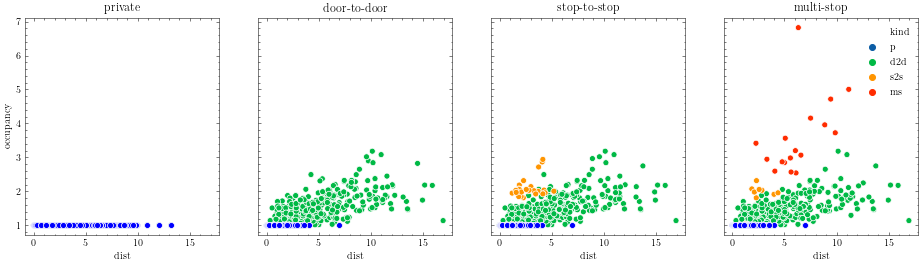

In [23]:
fig, ax = plt.subplots(1,4, figsize = (16,4), sharey = True, sharex= True)
ax = ax.flatten()
titles = ['private','door-to-door','stop-to-stop','multi-stop']
for level in [0,1,2,3]:
    solution = inData.transitize.rides[inData.transitize.rides['solution_{}'.format(level)] ==1]
    solution['ttrav_total'] = solution.apply(lambda x: inData.transitize.rm[inData.transitize.rm.ride == x.name].ttrav.sum(),axis = 1)
    solution['occupancy'] = solution['ttrav_total'] / solution['u_veh']
    solution['dist'] = solution.u_veh/1000*params.avg_speed
    sns.scatterplot(data = solution, x = 'dist', y = 'occupancy', hue = 'kind' , 
                    ax = ax[level])
    sns.scatterplot(data = solution[solution.kind == 'p'], x = 'dist', y = 'occupancy',
                    ax = ax[level], color = 'blue')
    ax[level].set_title(titles[level])
    if level <3:
        ax[level].get_legend().remove()

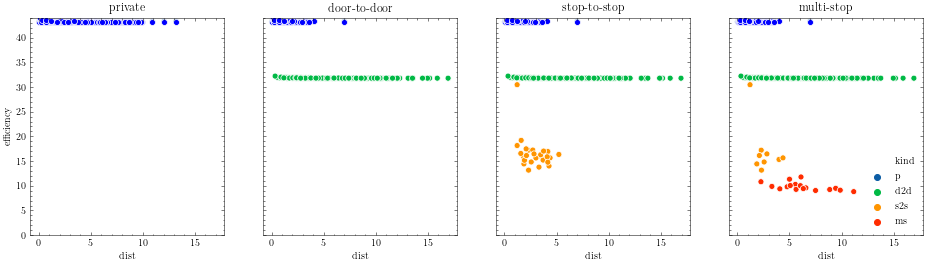

In [24]:
fig, ax = plt.subplots(1,4, figsize = (16,4), sharey = True, sharex= True)
ax = ax.flatten()
titles = ['private','door-to-door','stop-to-stop','multi-stop']
for level in [0,1,2,3]:
    solution = inData.transitize.rides[inData.transitize.rides['solution_{}'.format(level)] ==1]
    solution['ttrav_total'] = solution.apply(lambda x: inData.transitize.rm[inData.transitize.rm.ride == x.name].ttrav.sum(),axis = 1)
    solution['efficiency'] = solution['fare'] /solution['ttrav_total'] * 3600
    solution['dist'] = solution.u_veh/1000*params.avg_speed
    sns.scatterplot(data = solution, x = 'dist', y = 'efficiency', hue = 'kind' , 
                    ax = ax[level])
    sns.scatterplot(data = solution[solution.kind == 'p'], x = 'dist', y = 'efficiency',
                    ax = ax[level], color = 'blue')
    ax[level].set_title(titles[level])
    ax[level].set_ylim(0,44)
    if level <3:
        ax[level].get_legend().remove()

In [ ]:
rm['rel_dif'] = (rm.u - rm.u_private ) / rm.u

In [133]:
df = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(3)] ==1]
df['u_private'] = df.apply(lambda x: rm[(rm.traveller == x.traveller) &(rm.kind=='p') ].u.iloc[0], axis =1)
df = df[df.kind=='ms']

In [28]:
def utility_s2s(traveller):
    # utility of shared trip i for all the travellers
    return (params.price * traveller.fare +
            traveller.VoT * 1.1 * (traveller.ttrav + min(300,traveller.delay)) +
            traveller.VoT * 1 * (traveller.orig_walk_time + traveller.dest_walk_time))

In [56]:
df = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(level)] ==1]
df['u_private'] = df.apply(lambda x: rm[(rm.kind=='p')& (rm.traveller == x.traveller)].u.max(), axis =1)

In [57]:
df['u_n'] = df.apply(lambda x: utility_s2s(x), axis = 1)

In [58]:
df[df.u_n>df.u_private][['u','u_n','u_private', 'delay']]

,u,u_n,u_private,delay
701,4.79,4.40,4.29,327.0
284,4.68,3.68,3.63,471.5
1217,17.12,15.29,15.26,563.0


In [94]:
i=2


,index,origin,destination,treq,tarr,ttrav,origin_x,origin_y,destination_x,destination_y,...,ride_solution_1,ride_solution_2,ride_solution_3,PT_fare,fare_3,fare_2,u_3,u_2,u_1,u_0
0,116790,4519063338,46296911,0,2021-10-31 17:05:00,115,4.85,52.36,4.85,52.35,...,0,0,0,1.21,1.39,1.39,1.83,1.83,1.83,1.83
1,131638,46392276,896347490,0,2021-10-31 17:15:00,964,4.90,52.37,4.84,52.35,...,19736,19736,19736,2.13,8.51,8.51,14.73,14.73,14.73,14.73
2,133402,442122363,7191998618,0,2021-10-31 17:14:00,466,4.90,52.37,4.93,52.36,...,7176,7176,7176,1.55,4.11,4.11,6.78,6.78,6.78,6.78
3,167159,46315447,943758259,0,2021-10-31 17:15:00,1142,4.87,52.36,4.93,52.40,...,14954,25595,50086,1.96,3.43,10.08,15.28,16.80,16.53,16.53
4,62153,46405553,2028085129,1,2021-10-31 17:10:00,564,4.80,52.38,4.84,52.39,...,2457,2457,2457,1.68,4.98,4.98,7.82,7.82,7.82,7.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,44695,7887649557,46423608,597,2021-10-31 17:24:00,116,4.82,52.38,4.83,52.38,...,1295,1295,1295,1.04,1.40,1.40,1.88,1.88,1.88,1.88
1296,158052,46376895,46466787,597,2021-10-31 17:30:00,564,4.92,52.37,4.91,52.39,...,17303,17303,17303,1.38,4.98,4.98,7.79,7.79,7.79,7.79
1297,200292,46182244,46270691,597,2021-10-31 17:28:00,463,4.88,52.33,4.91,52.35,...,25570,25570,25570,1.96,4.09,4.09,6.24,6.24,6.24,6.24
1298,59533,46259317,46270683,599,2021-10-31 17:14:00,193,4.83,52.34,4.81,52.35,...,1298,1298,1298,1.05,2.32,2.32,3.05,3.05,3.05,3.05


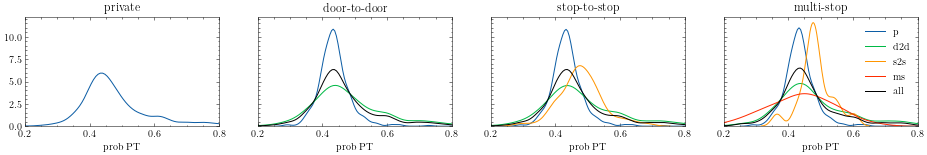

In [116]:
rm = inData.transitize.rm
fig, ax = plt.subplots(1,4, figsize = (16,2), sharey = True, sharex = True)
titles = ['private','door-to-door','stop-to-stop','multi-stop']
for level in [0,1,2,3]:
    df = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(level)] ==1]
    beta = -0.2
    df['prob PT'] = 1-df.apply(lambda x: math.exp(beta*x.u)/
                             (math.exp(beta*x.u)+math.exp(beta*inData.transitize.requests.loc[x.traveller].u_PT)),
                             axis = 1)
    df['logsum'] = df.apply(lambda x:math.log(math.exp(beta*x.u)+
                                              math.exp(beta*inData.transitize.requests.loc[x.traveller].u_PT)) -
                            math.log(math.exp(beta*inData.transitize.requests.loc[x.traveller].u_PT)), axis =1)
    #df['rel']= df.apply(lambda x:(x.u-inData.transitize.requests.loc[x.traveller].u_0)/inData.transitize.requests.loc[x.traveller].u_0, axis =1)
    #df = inData.transitize.requests['u_{}'.format(i)-inData.transitize.requests.u_0
    for kind in df.kind.unique():
        sns.distplot(df[df.kind == kind]['prob PT'],label = kind, ax = ax[level], hist = False)
        #ylim = ax[level].get_ylim()
        #ax[level].plot([df[df.kind == kind]['prob PT'].mean(),df[df.kind == kind]['prob PT'].mean()], (0,5),color = 'black', lw = 3)
        #ax[level].set_ylim(ylim)
    if level>0:
        sns.distplot(df['prob PT'],label = 'all', ax = ax[level], hist = False, color = 'black')
    if level == 3:
        ax[3].legend()
    if level <3:
         ax[level].get_legend().remove()
    ax[level].set_title(titles[level])
    ax[level].set_xlim((0.2,0.8))

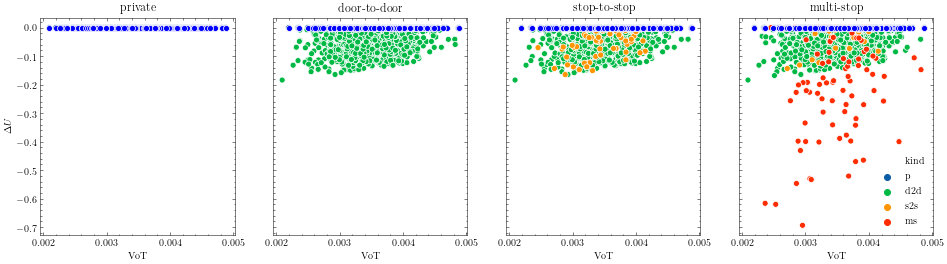

In [30]:
rm = inData.transitize.rm
fig, ax = plt.subplots(1,4, figsize = (16,4), sharey = True, sharex = True)
ax = ax.flatten()
titles = ['private','door-to-door','stop-to-stop','multi-stop']
for level in [0,1,2,3]:

    solution = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(level)] ==1].copy()
    #solution[solution.kind == 'ms'].u = solution[solution.kind == 'ms'].apply(lambda x: utility_s2s(x), axis =1) 
    solution['u_private'] = solution.apply(lambda x: rm[(rm.kind=='p')& (rm.traveller == x.traveller)].u.max(), axis =1)
    solution['$\Delta U$'] = np.minimum(0,(solution.u - solution.u_private ) / solution.u)
    sns.scatterplot(data = solution, x = 'VoT', y = '$\Delta U$', hue = 'kind' , 
                    ax = ax[level])
    sns.scatterplot(data = solution[solution.kind == 'p'], x = 'VoT', y = '$\Delta U$',
                    ax = ax[level], color = 'blue')
    
    ax[level].set_title(titles[level])
    if level <3:
        ax[level].get_legend().remove()